In [1]:
import os
os.chdir('/data-nfs/mujiang/git/unet-v2/')

In [2]:
import tifffile
import numpy as np
import cv2
from PIL import Image
from tqdm import tqdm
import math


import json
import cv2

import torch
import torchvision.transforms as T
from torchmetrics import JaccardIndex
from torch.utils.data import DataLoader

import vispy
from vispy.scene import SceneCanvas
from vispy import app

from datasets.reg_dataset_online import RegDataset as SegDataset_online
from models.unet import Unet
from models.unet_variants import UnetVariant



import matplotlib.pyplot as plt

from scipy.special import softmax
from osgeo import gdal, osr

# [1] prepare the data for test city: Shenzhen

In [11]:
#set the path to both s1 &s2, only need in combo mode
sentinel1_path = '/data-nfs/urban-econ/Sentinel1_Downloads/'
sentinel2_path = '/data-nfs/urban-econ/Sentinel2_Downloads/'
savepath = "/data-nfs/mujiang/city_prediction/"
model_path = "/data-nfs/sapar/experiments/hyperparameter/resnet34_backbone_04-05-2023_1/best_checkpoints/87epoch"

with open("/data-nfs/mujiang/git/unet-v2/configs/base.json", 'r') as f:
    config = json.load(f)


In [12]:
#city_list_selected = ['Baoding', 'Cangzhou', 'Foshan', 'Hangzhou', 'Hohhot', 'Jiaxing', 'Langfang', 'Linyi', 'Nanchang', 'Qinhuangdao', 'Shengyang', 'Shenzhen', 'Suzhou', 'Tai_2_zhou', 'Taiyuan', 'Tangshan', 'Weifang', 'Wuhu', 'Wuxi', 'Xi_an', 'Xuzhou', 'Yangzhou', 'Yantai', 'Yinchuan', 'Zaozhuang', 'Zhenjiang', 'Zhongshan', 'Zhuhai']
city_list_selected = ['Shenzhen']

In [13]:
def write_to_file(filename, data):
    with open(filename, 'a') as f:
        f.write(str(data))
        f.write('\n')

In [14]:
#input the whole image of city [x,y,6], return the predicted result [x,y,4]

def predict_city(RS_image,size=256):

    x_limit = math.floor(np.shape(RS_image)[0]/size)
    y_limit = math.floor(np.shape(RS_image)[1]/size)

    result_1 = np.zeros([np.shape(RS_image)[0],np.shape(RS_image)[1]]) +1000
    result_2 = np.zeros([np.shape(RS_image)[0],np.shape(RS_image)[1]]) +1000
    result_3 = np.zeros([np.shape(RS_image)[0],np.shape(RS_image)[1]]) +1000
    result_4 = np.zeros([np.shape(RS_image)[0],np.shape(RS_image)[1]]) +1000

    edge = 0

    print("path1")
    for i in tqdm(range(x_limit)):
        for j in range(y_limit):
            sub_RS_image =RS_image[i*size:(i+1)*size,j*size:(j+1)*size,:]
            
            data = SegDataset_online(sub_RS_image, config["norm"],  None)[0]            
            sub_result = predict_single_reg(model,data)
            
            result_1[i*size+edge : (i+1)*size-edge, j*size+edge : (j+1)*size-edge] = sub_result[edge:size-edge,edge:size-edge]
     
    print("path2")
    for i in tqdm(range(x_limit)):
        for j in range(y_limit):
            sub_RS_image =RS_image[np.shape(RS_image)[0]-(i+1)*size:np.shape(RS_image)[0]-i*size,np.shape(RS_image)[1]-(j+1)*size:np.shape(RS_image)[1]-j*size,:]
            
            data = SegDataset_online(sub_RS_image, config["norm"],  None)[0]            
            sub_result = predict_single_reg(model,data)
            
            result_2[np.shape(RS_image)[0]-(i+1)*size+edge : np.shape(RS_image)[0]-i*size-edge, np.shape(RS_image)[1]-(j+1)*size+edge : np.shape(RS_image)[1]-j*size-edge] = sub_result[edge:size-edge,edge:size-edge]

    
    
    
    print("path3")
    indent = int(size/2)    
    
    for i in tqdm(range(x_limit)):
        for j in range(y_limit):
            #sub_RS_image =RS_image[indent+i*size:indent+(i+1)*size,indent+j*size:indent+(j+1)*size,:]
            sub_RS_image =RS_image[np.shape(RS_image)[0]-(i+1)*size:np.shape(RS_image)[0]-i*size , j*size:(j+1)*size,:]
            
            data = SegDataset_online(sub_RS_image,config["norm"],  None)[0]            
            sub_result = predict_single_reg(model,data)
            
            result_3[np.shape(RS_image)[0]-(i+1)*size+edge : np.shape(RS_image)[0]-i*size -edge, j*size+edge:(j+1)*size-edge] = sub_result[edge:size-edge,edge:size-edge]
            
 
    print("path4")

    
    for i in tqdm(range(x_limit)):
        for j in range(y_limit):
            sub_RS_image =RS_image[i*size : (i+1)*size , np.shape(RS_image)[1]-(j+1)*size:np.shape(RS_image)[1]-j*size,:]
            
            data = SegDataset_online(sub_RS_image, config["norm"],  None)[0]            
            sub_result = predict_single_reg(model,data)
            
            result_4[i*size+edge : (i+1)*size-edge , np.shape(RS_image)[1]-(j+1)*size+edge : np.shape(RS_image)[1]-j*size-edge] = sub_result[edge:size-edge,edge:size-edge]

            
            
    # Create an empty matrix to store the results
    #result_sum = result_1 + result_2 + result_3 + result_4
    #result = result_sum - np.minimum.reduce([result_1, result_2, result_3, result_4]) - np.maximum.reduce([result_1, result_2, result_3, result_4])
    #result = result/2*400

            
    result = np.minimum.reduce([result_1, result_2, result_3, result_4])*400
    #result = np.exp(np.minimum.reduce([result_1, result_2, result_3, result_4]))
    #save to tiff format
    result[result<=1.5] = 0
        
    return result
    


In [15]:
#this function is for prediction single sub image [64,64,6]. input formate is dataset[i], return predicted [64,64,4]

def predict_single_reg(model,data):
    image = data["image"].unsqueeze(0)
    pred = model(image)["height"].detach().numpy()[0,0,:,:]
    
    return pred

In [16]:
#this function is for prediction single sub image [64,64,6]. input formate is dataset[i], return predicted [64,64,4]

def predict_single_class(model,data):
    image = data["image"].unsqueeze(0)
    pred = model(image)["pred"]


    cls = torch.softmax(pred, dim = 1).squeeze().detach().permute(1, 2, 0).numpy()


    #filter over max among all building types
    cls_building = np.max(cls[:,:,:3],axis=2)
    cls_building = np.repeat(cls_building[:, :, np.newaxis], 3, axis=2)
    cls_is_max_building = (cls_building == cls[:,:,:3])

    #only over 20% incluidng no building lands
    cls = cls > 0.2
    cls = cls_is_max_building * cls[:,:,:3]
    result = cls.astype(int)
    
    return result
 



In [17]:
def load_RS_building(sentinel1_path,sentinel2_path,city):
    
    intial = True
    
    
    for year in range(2015,2023,1):
        
        year = str(year)
        sentinel1_file = city + year + ".tif"
        sentinel2_file = city + year + ".tif"

        sentinel1_image = os.path.join(sentinel1_path ,"Sentinel1_" + city, sentinel1_file)
        sentinel2_image = os.path.join(sentinel2_path ,"Sentinel2_" + city, sentinel2_file)


        if ((os.path.isfile(sentinel1_image) == False) | (os.path.isfile(sentinel2_image) == False)):
            continue

        print(sentinel2_image)
        
        savepath_city = savepath + city
        if (os.path.isdir(savepath_city)== False):
            os.mkdir(savepath_city)  
            
            
        sentinel1_tif = np.asarray(tifffile.imread(sentinel1_image)).astype(np.float32)
        sentinel2_tif = np.asarray(tifffile.imread(sentinel2_image)).astype(np.float32)

        
        #this is the input data of the whole city
        combo_tif = np.dstack((sentinel1_tif,sentinel2_tif))[:,:,:6]
        result = predict_city(combo_tif,size=256)
        
        
        file_name = city + "_" + year + ".tiff"         
        save_file = os.path.join(savepath,city,file_name)
        print("save to: " + save_file)
        tifffile.imwrite(save_file, result)
        
        
        #georeferencing
        src = gdal.Open(sentinel2_image)
        ulx, xres, xskew, uly, yskew, yres  = src.GetGeoTransform()
        print(src.GetGeoTransform)
        
        ds_img = gdal.Open(save_file)     
        ds_img.SetGeoTransform([ulx, xres, xskew, uly, yskew, yres])
        
        # Get raster projection
        epsg = 4326
        srs = osr.SpatialReference()
        srs.ImportFromEPSG(epsg)
        dest_wkt = srs.ExportToWkt()

        # Set projection
        ds_img.SetProjection(dest_wkt)

        # Close files
        ds_img = None
        src = None

        
 

In [18]:
model= UnetVariant(config["model"])

model.load_state_dict(torch.load(model_path, map_location=torch.device('cuda')))
model.eval()


#load_RS_building(sentinel1_path,sentinel2_path,city_list_selected[0])

for city in city_list_selected:
    load_RS_building(sentinel1_path,sentinel2_path,city)

/data-nfs/urban-econ/Sentinel2_Downloads/Sentinel2_Shenzhen/Shenzhen2018.tif
path1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:24<00:00,  1.65s/it]


path2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:20<00:00,  1.39s/it]


path3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:19<00:00,  1.30s/it]


path4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:24<00:00,  1.61s/it]


save to: /data-nfs/mujiang/city_prediction/Shenzhen/Shenzhen_2018.tiff
<bound method Dataset.GetGeoTransform of <osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7fb972be6ae0> >>
/data-nfs/urban-econ/Sentinel2_Downloads/Sentinel2_Shenzhen/Shenzhen2019.tif
path1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:23<00:00,  1.56s/it]


path2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:25<00:00,  1.68s/it]


path3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:25<00:00,  1.67s/it]


path4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:22<00:00,  1.47s/it]


save to: /data-nfs/mujiang/city_prediction/Shenzhen/Shenzhen_2019.tiff
<bound method Dataset.GetGeoTransform of <osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7fb9731b79c0> >>
/data-nfs/urban-econ/Sentinel2_Downloads/Sentinel2_Shenzhen/Shenzhen2020.tif
path1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:24<00:00,  1.63s/it]


path2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:24<00:00,  1.62s/it]


path3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:24<00:00,  1.66s/it]


path4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:23<00:00,  1.59s/it]


save to: /data-nfs/mujiang/city_prediction/Shenzhen/Shenzhen_2020.tiff
<bound method Dataset.GetGeoTransform of <osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7fb975444f90> >>
/data-nfs/urban-econ/Sentinel2_Downloads/Sentinel2_Shenzhen/Shenzhen2021.tif
path1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:25<00:00,  1.67s/it]


path2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:27<00:00,  1.84s/it]


path3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:24<00:00,  1.67s/it]


path4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:22<00:00,  1.53s/it]


save to: /data-nfs/mujiang/city_prediction/Shenzhen/Shenzhen_2021.tiff
<bound method Dataset.GetGeoTransform of <osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7fb975455cc0> >>
/data-nfs/urban-econ/Sentinel2_Downloads/Sentinel2_Shenzhen/Shenzhen2022.tif
path1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:24<00:00,  1.61s/it]


path2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:25<00:00,  1.69s/it]


path3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:25<00:00,  1.67s/it]


path4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:25<00:00,  1.69s/it]


save to: /data-nfs/mujiang/city_prediction/Shenzhen/Shenzhen_2022.tiff
<bound method Dataset.GetGeoTransform of <osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7fb975437900> >>


## this is for testing single part of image

In [21]:
sentinel1_path = '/data-nfs/urban-econ/Sentinel1_Downloads/Sentinel1_Shenzhen/Shenzhen2018.tif'
s1_image  = tifffile.imread(sentinel1_path).astype(np.float32)
#plt.imshow(conver_255(s_image[64*20:64*30,64*20:64*30,0:3]))
sentinel2_path = '/data-nfs/urban-econ/Sentinel2_Downloads/Sentinel2_Shenzhen/Shenzhen2018.tif'
s2_image  = tifffile.imread(sentinel2_path)[:,:,:4].astype(np.float32)

j = 0
k = 0

data = SegDataset_online(np.dstack((s1_image,s2_image))[256*j:256*(j+1),256*k:256*(k+1),:],config["norm"],None)[0]

result = predict_single_reg(model,data)

In [24]:
result[:64,:64]

(256, 256)

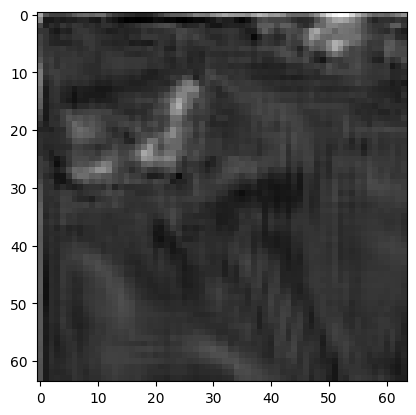

In [29]:
plt.imshow(result[:64,:64],cmap="gray")